In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import loader

/Users/skim0119/github/chess_godeep/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Pepare Dataset
x_train, t_train = loader.load()
x_train = np.stack(x_train)
t_train = np.stack(t_train)

418819 data loaded


In [3]:
def batch_data(size, x_train, t_train):
    sup_index = len(x_train)
    indices = np.random.randint(0,sup_index,size)
    return x_train[indices], t_train[indices]

In [4]:
#Graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 8, 8, 6)) # input layer
t = tf.placeholder(tf.float32, shape=(None, 2)) # return probability of either side winning (sigmoid)

global_step = tf.Variable(0, trainable=False, name='global_step')

with tf.name_scope('conv1'):
    # First convolution filter with kernel size 2x2, and pool by 2x2
    # input : [8, 8, 6]
    # output : [4,4,24]
    kernel_1 = tf.Variable(tf.random_uniform([2,2,6,24], -1.0, 1.0))
    conv1 = tf.nn.conv2d(x, kernel_1, strides=[1,1,1,1], padding = 'SAME')
    conv1_act = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1_act, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    #x = tf.nn.dropout(x, 0.5)

with tf.name_scope('conv2'):
    # First convolution filter with kernel size 2x2
    # input : [4,4,24]
    # output : [4,4,48]
    kernel_2 = tf.Variable(tf.random_uniform([2,2,24,48], -1.0, 1.0))
    conv2 = tf.nn.conv2d(conv1_pool, kernel_2, strides=[1,1,1,1], padding = 'SAME')
    conv2_act = tf.nn.relu(conv2)
    #x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,1,1,1], padding = 'SAME')

with tf.name_scope('Dense1'):
    length = 4*4*48
    x_flat = tf.reshape(conv2_act, [-1,length]) # flatten
    weight_1 = tf.Variable(tf.truncated_normal(shape=[length, 2]))
    bias_1 = tf.Variable(tf.truncated_normal(shape=[2]))
    dense1 = tf.matmul(x_flat, weight_1) + bias_1
    output = tf.sigmoid(dense1)

"""
with tf.name_scope('Dense2'):
    # softmax
    weight_2 = tf.Variable(tf.truncated_normal(shape=[length, 2]))
    bias_2 = tf.Variable(tf.truncated_normal(shape=[2]))
    dense2 = tf.matmul(dense1, weight_2) + bias_2
    output = tf.sigmoid(dense2)
"""
with tf.name_scope('optimizer'):
    Loss = tf.reduce_mean(tf.square(output - t))
    Optimizer = tf.train.AdamOptimizer().minimize(Loss, global_step=global_step)
    tf.summary.scalar('loss', Loss)

In [43]:
# Session
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    
# Save
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./logs', sess.graph)
    
loss_table = []

# Epoch
max_epoch = 10000
progbar = tf.keras.utils.Progbar(max_epoch)
for epoch in range(max_epoch):
    progbar.update(epoch) # update progress bar
    
    x_train_batch, t_train_batch = batch_data(50, x_train, t_train)

    feed_dict = {x:x_train_batch, t:t_train_batch}
    _, loss = sess.run([Optimizer, Loss], feed_dict=feed_dict)
    loss_table.append(loss)
    
    if epoch % 1000 == 0:
        print(epoch, "epoch, Loss : ", loss)
    
    summary = sess.run(merged, feed_dict=feed_dict)
    writer.add_summary(summary, global_step=sess.run(global_step))

saver.save(sess, './model/chess.ckpt', global_step=global_step)

INFO:tensorflow:Restoring parameters from ./model/chess.ckpt-35000
 9994/10000 [============================>.] - ETA: 0s

'./model/chess.ckpt-45000'

Final Loss Value :  0.22695394


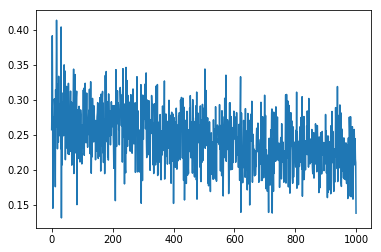

In [44]:
# Loss Graph
plt.plot(loss_table[1::10]) # Draw loss graph for every 10 training epoch
print('Final Loss Value : ', loss_table[-1])

In [53]:
# Prediction and Accuracy
sample_size = 1000
x_test, t_test = batch_data(sample_size, x_train, t_train)
result = sess.run(output, feed_dict={x:x_test})

correct_prediction = 0
for i in range(sample_size):
    if (result[i][0] > result[i][1] and t_test[i][0]) \
        or (result[i][0] < result[i][1] and t_test[i][1]): # Black winning prediction
        correct_prediction += 1
        
print("Percentage of Correct Prediction : ", correct_prediction / sample_size)

Percentage of Correct Prediction :  0.677
